In [42]:
import numpy as np
from matplotlib import pyplot as plt

In [43]:
def generate_binary_matrix(q):
    # Create a 1000x1000 binary matrix initialized with ones
    matrix = np.ones((1000, 1000), dtype=int)
    
    # Define a random slope and intercept for the line
    slope = np.random.uniform(-1,1)
    intercept = np.random.uniform(0,1000)
    
    for i in range(1000):
        for j in range(1000):
            # Calculate the expected position of the line for this column
            expected_position = slope * i + intercept
            
            # Determine if the point is on one side or the other of the line
            if j <= expected_position:
                matrix[i, j] = 0  # Black
                
            # Flip the point with probability q
            if np.random.rand() < q:
                matrix[i, j] = 1 - matrix[i, j]
    
    return matrix

In [44]:
#Binary search to find white and black point with distance less than (epsilon*n)/2
def binary_search(matrix, epsilon, index, value):

    n = matrix.shape[0]
    left, right = 0, n-1
    w, b = None, None

    #Checking which index to fix on matrix, Fixing index 0
    #Top or Bottom Side
    if index == 0:

        #If white region is on the left side
        if matrix[value,0] == 1:
            w = (value,0)
            b = (value, n-1)

            #Running binary search until the distance is less than (epsilon*n)/2
            while left <= right:
                mid = (left + right) // 2
                if abs(w[1] - b[1]) < (epsilon*n)//2:
                    return w, b
                if matrix[value, mid] == 0:
                    b = (value, mid)
                    right = mid - 1
                else:
                    w = (value, mid)
                    left = mid + 1
        
        #If white region is on the right side
        else:
            w = (value, n-1)
            b = (value, 0)

            #Running binary search until the distance is less than (epsilon*n)/2
            while left <= right:
                mid = (left + right) // 2
                if abs(w[1] - b[1]) < (epsilon*n)//2:
                    return w, b
                if matrix[value, mid] == 1:
                    w = (value, mid)
                    right = mid - 1
                else:
                    b = (value, mid)
                    left = mid + 1
    
    #Fixing index 1
    #Left or Right Side        
    else:
        
        #If white region is on the left side
        if matrix[0,value] == 1:
            w = (0,value)
            b = (n-1, value)
            
            #Running binary search until the distance is less than (epsilon*n)/2
            while left <= right:
                mid = (left + right) // 2
                if abs(w[0] - b[0]) < (epsilon*n)//2:
                    return w, b
                if matrix[mid, value] == 0:
                    b = (mid, value)
                    right = mid - 1
                else:
                    w = (mid, value)
                    left = mid + 1
        
        #If white region is on the left side
        else:
            w = (n-1, value)
            b = (0,value)

            #Running binary search until the distance is less than (epsilon*n)/2
            while left <= right:
                mid = (left + right) // 2
                if abs(w[0] - b[0]) < (epsilon*n)//2:
                    return w, b
                if matrix[mid, value] == 1:
                    w = (mid, value)
                    right = mid - 1
                else:
                    b = (mid, value)
                    left = mid + 1
    return w,b

In [45]:
#Calculating line to get sample from outside region
def calculate_line_equation(point1, point2):
    if point1[0] == point2[0]:    
        m = (point2[1] - point1[1])
    else:
        m = (point2[1] - point1[1]) / (point2[0] - point1[0])
    b = point1[1] - m * point1[0]
    return m, b

In [46]:
def test_half_plane(matrix, p, epsilon):
    
    n = matrix.shape[0]

    #Corners of the image
    corners = [matrix[0,0], matrix[0,n-1], matrix[n-1,n-1], matrix[n-1,0]]
    
    #Checking which side has different colored corners
    sides = [
        #top
        1 if matrix[0,0] == matrix[0, n-1] else -1,
        #right
        1 if matrix[0,n-1] == matrix[n-1, n-1] else -1,
        #botton
        1 if matrix[n-1,0] == matrix[n-1, n-1] else -1,
        #left
        1 if matrix[0,0] == matrix[n-1, 0] else -1,
    ]
    
    #Count the number of sides with differently colored corners
    sideSet = set(sides)
    s = len(set(sides))

    sideSet = list(sideSet)
    
    #Case 1: All four sides have different color endpoint 
    if s == 1 and sideSet[0] == -1:
        return False
    
    #Case 2: No sides have different color endpoints
    elif s == 1 and sideSet[0] == 1:
        # Query ln(1/1-p)/epsilon pixels independently at random
        queried_pixels = []     
        sample_size = int(np.log(1/(1-p))/epsilon)
        for _ in range(sample_size):
            queried_pixels.append(matrix[np.random.randint(n),np.random.randint(n)])
        return True if len(set(queried_pixels)) == 1 else False

    # Case 3: Two sides have different color endpoints
    elif s == 2:
        #Sides that have different color endpoints
        side1 = sides.index(-1)
        side2 = sides.index(-1, side1 + 1)

        w1, b1, w2, b2 = None, None, None, None

        #Setting which index to fix in the binary search and with what value
        #This is because we are traversing over sides of matrix, so one value is always fixed
        side_map = {
            (0, 1): ((0, 0), (1, n-1)),
            (1, 2): ((1, n-1), (0, n-1)),
            (2, 3): ((0, n-1), (1, 0)),
            #inverted coordinates to fix a case
            (0, 3): ((1, 0), (0, 0)),
            (1, 3): ((1, n-1), (1, 0)),
            (0, 2): ((0, 0), (0, n-1))
        }

        #Running binary search on the chosen sides
        if (side1, side2) in side_map:
            w1, b1 = binary_search(matrix, epsilon, side_map[(side1, side2)][0][0], side_map[(side1, side2)][0][1])
            w2, b2 = binary_search(matrix, epsilon, side_map[(side1, side2)][1][0], side_map[(side1, side2)][1][1])

        #Calculating Line equation
        m1, c1 = calculate_line_equation(w1, w2)
        m2, c2 = calculate_line_equation(b1, b2)
           
        #Randomly picking sample size points
        sample_size = int(2*np.log(1/(1-p))/epsilon)
        while sample_size > 0:
            #Randomly picking a point in matrix
            x = np.random.randint(0, n)
            y = np.random.randint(0, n)

            #Calculating how far is the point from both the lines
            y_line1 = m1 * x + c1 if m1 * x + c1 <= 999 else (0 if m1 * x + c1 <= 0 else 999)
            y_line2 = m2 * x + c2 if m2 * x + c2 <= 999 else (0 if m1 * x + c1 <= 0 else 999)

            #Check If the point is on the left of both the lines
            if (y < min(y_line1, y_line2)):
                #Check If the point is white, and white region is on the left
                if w1[0] == b1[0] and w1[1] < b1[1] and matrix[x][y] == 1:
                    sample_size -= 1
                #Check If the point is black, and black region is on the left
                elif w1[0] == b1[0] and w1[1] > b1[1] and matrix[x][y] == 0:
                    sample_size -= 1
                #Check If the point is white, and white region is on the top
                elif w1[1]==b1[1] and w1[0] < b1[0] and matrix[x][y] == 1:
                    sample_size -= 1
                #Check If the point is black, and black region is on the top
                elif w1[1]==b1[1] and w1[0] > b1[0] and matrix[x][y] == 0:
                    sample_size -= 1
                #White point on black region, or black point on white region
                else:
                    return False
            #If the point is on the right of both the lines
            elif (y > max(y_line1, y_line2)):
                #Check If the point is black, and black region is on the right
                if w1[0] == b1[0] and w1[1] < b1[1] and matrix[x][y] == 0:
                    sample_size -= 1
                #Check If the point is white, and white region is on the right
                elif w1[0] == b1[0] and w1[1] > b1[1] and matrix[x][y] == 1:
                    sample_size -= 1
                #Check If the point is black, and black region is on the bottom
                elif w1[1]==b1[1] and w1[0] < b1[0] and matrix[x][y] == 0:
                    sample_size -= 1
                #Check If the point is white, and white region is on the bottom
                elif w1[1]==b1[1] and w1[0] > b1[0] and matrix[x][y] == 1:
                    sample_size -= 1
                #White point on black region, or black point on white region
                else:
                    return False
            ##If the point is between the lines, we ignore
            else:
                continue

        return True
                
    else:
        return False

In [90]:
#Setting values of all the parameters
epsilon_values = [0.01, 0.1, 0.3]
q_values = [0.01, 0.02, 0.03, 0.04, 0.05]
p = 0.99
eresults = {}
matrixes = {}

#Running for each value of epsilon
for epsilon in epsilon_values:
    eresults[epsilon] = {}
    matrixes[epsilon] = {}
    #Generating one image per q
    for q in q_values:
        matrix = generate_binary_matrix(q)
        matrixes[epsilon][q] = matrix
        res = []
        #Testing the algorithm 50 times
        for _ in range(50):
            res.append(test_half_plane(matrix, p, epsilon))
        eresults[epsilon][q] = res

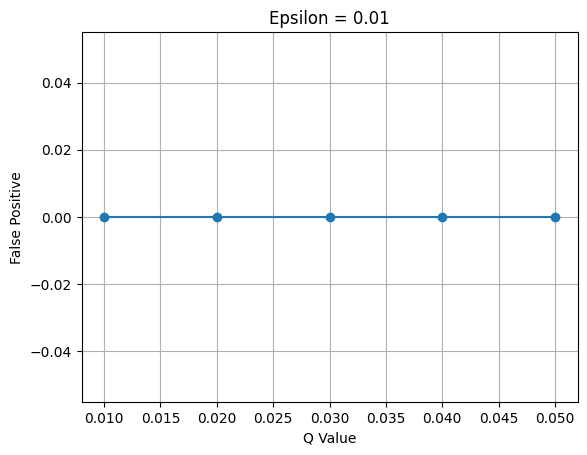

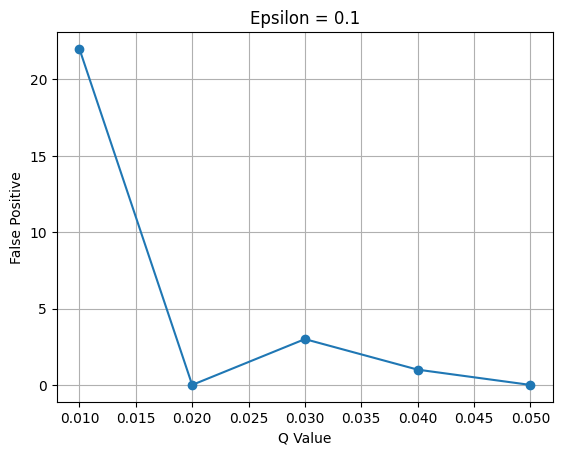

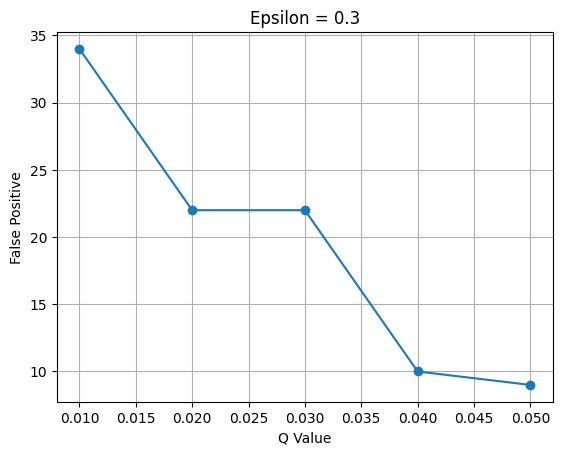

In [94]:
#Calculating false positive rate for each case
for epsilon, q_dict in eresults.items():
    q_values = []
    false_positive = []
    for q, results in q_dict.items():
        q_values.append(q)
        if q == 0:
            false_positive.append(results.count(False))
        else:
            false_positive.append(results.count(True))
    #Plotting the graph for each case
    plt.figure()
    plt.plot(q_values, false_positive, marker='o', linestyle='-')
    plt.xlabel('Q Value')
    plt.ylabel('False Positive')
    plt.title(f'Epsilon = {epsilon}')
    plt.grid(True)
    plt.show()

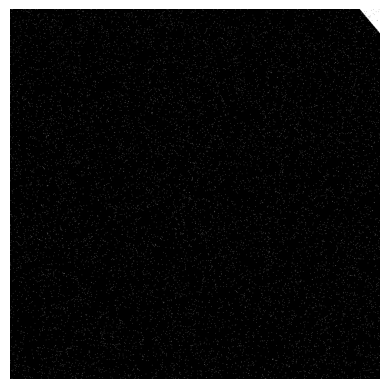

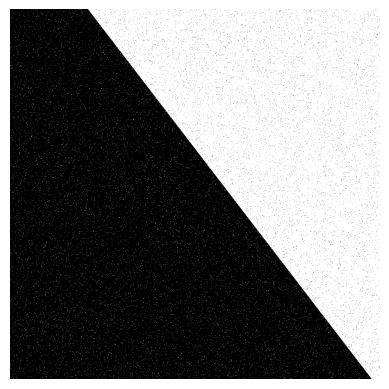

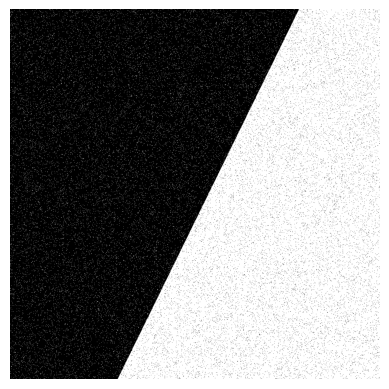

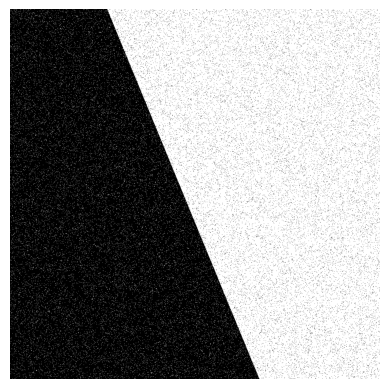

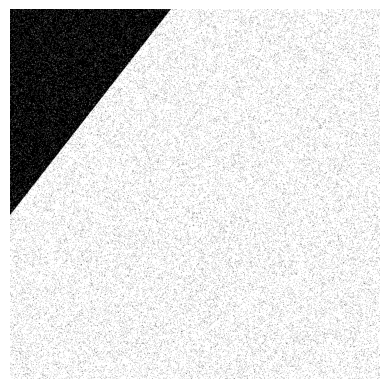

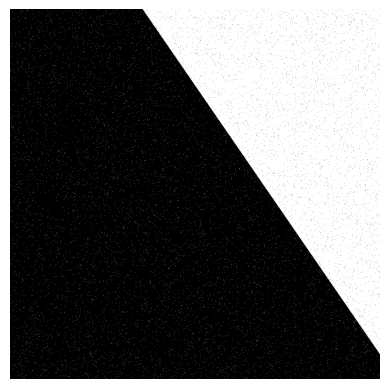

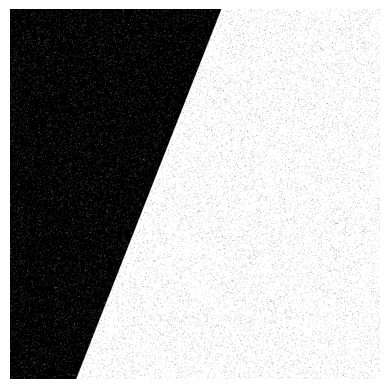

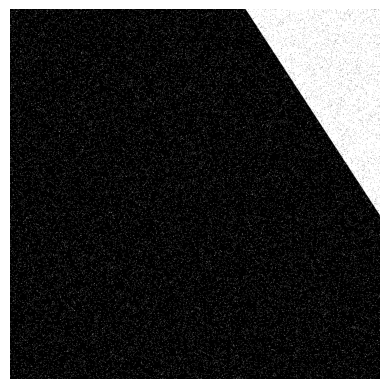

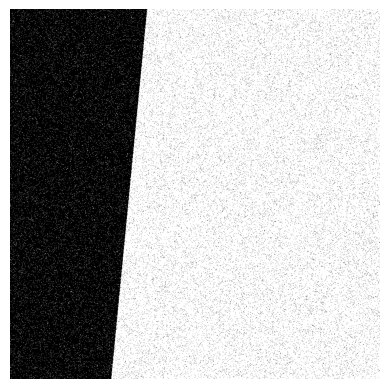

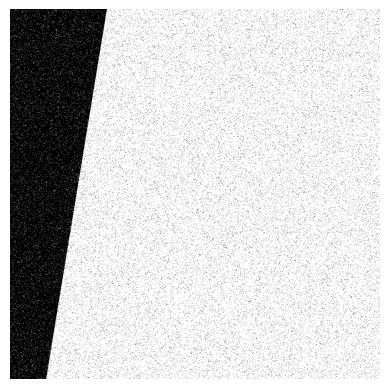

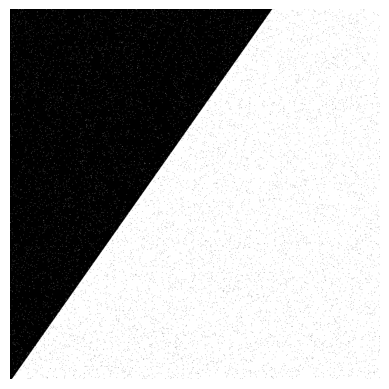

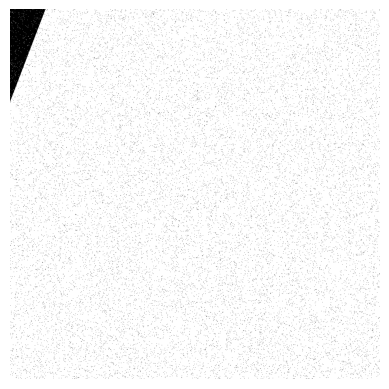

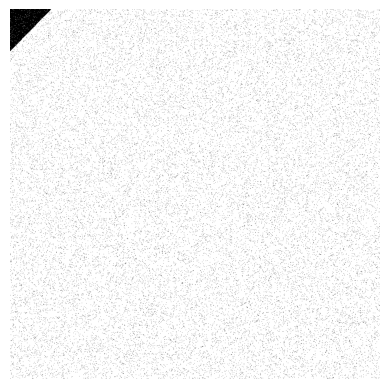

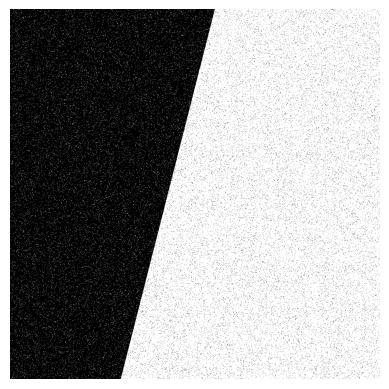

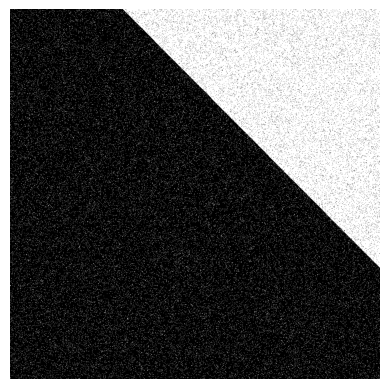

In [92]:
for epsilon, q_dict in matrixes.items():
    for q, matrix in q_dict.items():
        plt.imshow(matrix, cmap='gray')
        plt.axis('off')
        plt.show()